In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import functools
import seaborn as sn
from tqdm import tqdm
from sklearn import preprocessing
from scipy.stats import entropy
from numpy import logical_and as land, logical_or as lor
from utilities import to_float, plot_boxplot, plot_hist, get_path

In [2]:
DATA_PATH = get_path()

In [3]:
df_tweets = pd.read_csv(DATA_PATH+'tweets_no_dupl_1.5.csv', sep='#')
df_users = pd.read_csv(DATA_PATH+'users_clean.csv', sep='#')

# Tweets csv cleaning

## id
In the id column there are only two missing values. Since the column is not meaningful for the analysis phase, the column is dropped.

In [4]:
df_tweets.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9816550 entries, 0 to 9816549
Data columns (total 13 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   level_0          9816550 non-null  int64  
 1   id               9816550 non-null  object 
 2   user_id          9741564 non-null  object 
 3   created_at       9816550 non-null  object 
 4   text             9720352 non-null  object 
 5   retweet_count    9816550 non-null  float64
 6   reply_count      9816550 non-null  float64
 7   favorite_count   9816550 non-null  float64
 8   num_hashtags     9816550 non-null  float64
 9   num_urls         9816550 non-null  float64
 10  num_mentions     9816550 non-null  float64
 11  user_id_conv     9816550 non-null  float64
 12  created_at_conv  9816550 non-null  int64  
dtypes: float64(7), int64(2), object(4)
memory usage: 973.6+ MB


In [5]:
df_tweets.drop(columns=['id'], inplace=True)

## user_id
In the user_id column there are a lot of missing values, wrong values (non-numerical ids) and a lot of user ids do not have any correspondence with users file. Nevertheless, these records have been kept because the other columns could be useful for future analyses.

No records which have both user_id and text values which are null exist.

In [6]:
df_tweets[np.logical_and(df_tweets['user_id'].isnull(), df_tweets['text'].isnull())].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   level_0          0 non-null      int64  
 1   user_id          0 non-null      object 
 2   created_at       0 non-null      object 
 3   text             0 non-null      object 
 4   retweet_count    0 non-null      float64
 5   reply_count      0 non-null      float64
 6   favorite_count   0 non-null      float64
 7   num_hashtags     0 non-null      float64
 8   num_urls         0 non-null      float64
 9   num_mentions     0 non-null      float64
 10  user_id_conv     0 non-null      float64
 11  created_at_conv  0 non-null      int64  
dtypes: float64(7), int64(2), object(3)
memory usage: 0.0+ bytes


Merge users table with tweets table by user_id

In [7]:
df_users.id = df_users.id.astype(str)
merged = df_tweets.merge(df_users, left_on='user_id', right_on='id', how='left')

In [8]:
df_tweets.shape

(9816550, 12)

Number of `user_id` that have no correspondance in users file.

In [9]:
len(merged[merged['id'].isnull()].user_id.unique())

129040

## File checkpoint

In [10]:
df_tweets.to_csv(path_or_buf=DATA_PATH+'tweets_no_ids.csv', sep='#', index=False)
df_users.to_csv(path_or_buf=DATA_PATH+'users_no_ids.csv', sep='#', index=False)

In [11]:
df_tweets = pd.read_csv(DATA_PATH+'tweets_no_ids.csv', sep='#')
df_users = pd.read_csv(DATA_PATH+'users_no_ids.csv', sep='#')

# Convert to float

Cast column values to float (there are numbers too big for int) and set to -1.0 when there is a value which is not a number or an uncastable value (e.g. string)

In [12]:
df_tweets['retweet_count_conv'] = df_tweets.retweet_count.apply(to_float)

In [13]:
df_tweets['reply_count_conv'] = df_tweets.reply_count.apply(to_float)

In [14]:
df_tweets['favorite_count_conv'] = df_tweets.favorite_count.apply(to_float)

In [15]:
df_tweets['num_hashtags_conv'] = df_tweets.num_hashtags.apply(to_float)

In [16]:
df_tweets['num_urls_conv'] = df_tweets.num_urls.apply(to_float)

In [17]:
df_tweets['num_mentions_conv'] = df_tweets.num_mentions.apply(to_float)

In [18]:
df_tweets['created_at_conv'] = pd.to_datetime(df_tweets['created_at']).astype(np.int64)

## File checkpoint

In [19]:
df_tweets.to_csv(path_or_buf=DATA_PATH+'tweets_to_float.csv', sep='#', index=False)
df_users.to_csv(path_or_buf=DATA_PATH+'users_to_float.csv', sep='#', index=False)

In [22]:
df_tweets = pd.read_csv(DATA_PATH+'tweets_to_float.csv', sep='#')
df_users = pd.read_csv(DATA_PATH+'users_to_float.csv', sep='#')

# Utilities

In [20]:
def show_statistics(df, col, log=False, norm=False):
    #Extract statistical indicators from the indicated column
    mean = np.mean(df[col].values)
    median = np.median(df[col].values)

    # Normalize values
    if norm:
        norm_col = preprocessing.MinMaxScaler().fit_transform(np.array(df[col].values).reshape(1, -1).T)
        entr = entropy(norm_col)[0]
    else:
        entr = entropy(df[col])

    print("mean: " + str(mean))
    print("median: " + str(median))
    print("entropy: " + str(entr))
    plot_boxplot(df,col, log)

In [21]:
def fix_values(df, col, replace_condition=None, replace_value=None):
    #Substitute all the -1.0 values (missing values) with the median
    if replace_condition is None:
        median = np.median(df[col].values)
        df[col] = df[col].replace({-1.0: median})
    else:
        if replace_value is None:
            # Replace values is set to median of all records which don't fit the condition
            replace_value = df[~replace_condition][col].median()
        # All records which fit the replace_condition are replaced
        df.loc[replace_condition, col] = replace_value

    return df

In [22]:
def check_var_attribute(df, attribute_name):
    # all values which are not null, are not infinity and are not noisy (-1)
    df = df[(df[attribute_name].isnull() != True) & (df[attribute_name] != np.inf) & (df[attribute_name] != -1)]
    df = df[['user_id', attribute_name]]
    # Extract statistical indicators of attributes by user
    df = df.groupby(by=['user_id']).agg(["mean", "median", "var"])[attribute_name]

    return df

In [23]:
def replace_with_user_median(df_to_replace, attribute_name, threshold=1e7, replace_tweets_condition=None):

    if replace_tweets_condition is None:
        #Get all the rows to edit
        replace_tweets_condition = ((df_to_replace[attribute_name] == -1) | (df_to_replace[attribute_name] > threshold))

    # users to replace
    condition_users = df_to_replace.user_id.isin(df_to_replace[replace_tweets_condition].user_id)

    keep_condition = ~replace_tweets_condition

    # Median for that users that have not a correspondance in the user file
    glob_median = df_to_replace[keep_condition][attribute_name].median()

    # Merge users to replace and users dataset
    df_users.id = df_users.id.astype(str)
    df_to_replace.user_id = df_tweets.user_id.astype(str)
    df_merge = df_to_replace.merge(df_users, left_on='user_id', right_on='id', how='left')

    # Median for bot users
    bot_median = df_merge[keep_condition & df_merge['bot'] == 0][attribute_name].median()

    # Median for non bot users
    non_bot_median = df_merge[keep_condition & df_merge['bot'] == 1][attribute_name].median()

    # All the tweets that can be used for median computation of the selected users
    condition_for_median = keep_condition & condition_users

    # For each user of the previous list it extract median and var for the indicated attribute
    df_stats = df_to_replace[condition_for_median].groupby(by=['user_id']).agg(["median", "var"])[attribute_name]

    # Add these values to the original DataFrame
    df_to_replace = df_to_replace.merge(df_stats, left_on='user_id', right_on='user_id', how='left')

    '''
    Get all the users that have just one tweet and so we use median to substitute the indicated 
    column based on the user type (genuine vs. non-bot vs. unknown)
    '''
    condition_one_tweet = df_to_replace['var'].isnull() == True & condition_users

    condition_one_tweet_non_bot = ((df_merge.bot == 0) & (condition_one_tweet))
    condition_one_tweet_bot = ((df_merge.bot == 1) & (condition_one_tweet))
    condition_one_tweet_others = (df_merge.bot.isnull() & condition_one_tweet)

    df_to_replace.loc[condition_one_tweet_non_bot, attribute_name] = non_bot_median
    df_to_replace.loc[condition_one_tweet_bot, attribute_name] = bot_median
    df_to_replace.loc[condition_one_tweet_others, attribute_name] = glob_median

    # Substitute wrong values with the median of the user that has more than one tweet
    condition_more_tweet = ((df_to_replace[attribute_name] != glob_median) & (df_to_replace[attribute_name] != non_bot_median) & (df_to_replace[attribute_name] != bot_median) & (condition_users))
    df_to_replace.loc[condition_more_tweet, attribute_name] = df_to_replace[condition_more_tweet]['median']

    df_to_replace.drop(columns=['median','var'], inplace=True)

    return df_to_replace

In [24]:
def check_bot_stats_diff(col):

    # Select users in users file and their tweets
    df_users.id = df_users.id.astype(str)
    df_tweets.user_id = df_tweets.user_id.astype(str)
    df_merge = df_tweets.merge(df_users, left_on='user_id', right_on='id', how='right')

    # Select values which are non noisy for the selected column
    df_merge_clean = df_merge[(df_merge[col] != -1) & (df_merge[col] < np.inf)]

    # Compute statistics for bots
    median_bot = df_merge_clean[df_merge_clean['bot'] == 1][col].median()
    mean_bot = df_merge_clean[df_merge_clean['bot'] == 1][col].mean()
    entropy_bot = entropy(df_merge_clean[df_merge['bot'] == 1][col])

    # Compute statistics for genuine users
    median_non_bot = df_merge_clean[df_merge_clean['bot'] == 0][col].median()
    mean_non_bot = df_merge_clean[df_merge_clean['bot'] == 0][col].mean()
    entropy_non_bot = entropy(df_merge_clean[df_merge_clean['bot'] == 0][col])

    # Compute statistics for all values
    median_all = df_merge_clean[col].median()
    mean_all = df_merge_clean[col].mean()
    entropy_all = entropy(df_merge_clean[col])

    print(col + ":")
    print("\tmedian bot: " + str(median_bot) + " median non bot: " + str(median_non_bot) + " median all: " + str(median_all))
    print("\tmean bot: " + str(mean_bot) + " mean non bot: " + str(median_non_bot) + " mean all: " + str(mean_all))
    print("\tentropy bot: " + str(entropy_bot) + " entropy non bot: " + str(median_non_bot) + " entropy all: " + str(entropy_all))

# Preliminary checks

Compute statistics for each attribute

In [25]:
attrs = ["retweet_count", "reply_count", "favorite_count", "num_mentions", "num_urls", "num_hashtags"]
for attr in attrs:
    check_bot_stats_diff(attr)
    print("----------------------------------------------")

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_20764\4262826634.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  entropy_bot = entropy(df_merge_clean[df_merge['bot'] == 1][col])


retweet_count:
	median bot: 0.0 median non bot: 0.0 median all: 0.0
	mean bot: 5.866164053730542e+127 mean non bot: 0.0 mean all: 2.081508544176272e+127
	entropy bot: 3.985677208842243e-48 entropy non bot: 0.0 entropy all: 3.9856776060011144e-48
----------------------------------------------


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_20764\4262826634.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  entropy_bot = entropy(df_merge_clean[df_merge['bot'] == 1][col])


reply_count:
	median bot: 0.0 median non bot: 0.0 median all: 0.0
	mean bot: 5.866449686247869e+103 mean non bot: 0.0 mean all: 2.081700499504129e+103
	entropy bot: 1.4280201805310366e-12 entropy non bot: 0.0 entropy all: 1.428020180549496e-12
----------------------------------------------


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_20764\4262826634.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  entropy_bot = entropy(df_merge_clean[df_merge['bot'] == 1][col])


favorite_count:
	median bot: 0.0 median non bot: 0.0 median all: 0.0
	mean bot: 2.22915084018631e+93 mean non bot: 0.0 mean all: 7.285484629396764e+204
	entropy bot: 2.2790066351209307e-11 entropy non bot: 0.0 entropy all: 2.7990506023023497e-110
----------------------------------------------


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_20764\4262826634.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  entropy_bot = entropy(df_merge_clean[df_merge['bot'] == 1][col])


num_mentions:
	median bot: 0.0 median non bot: 1.0 median all: 0.0
	mean bot: 1.7600076971003286e+81 mean non bot: 1.0 mean all: 6.245663231135546e+80
	entropy bot: 1.237315576890967e-34 entropy non bot: 1.0 entropy all: 1.9812597641766234e-07
----------------------------------------------


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_20764\4262826634.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  entropy_bot = entropy(df_merge_clean[df_merge['bot'] == 1][col])


num_urls:
	median bot: 0.0 median non bot: 0.0 median all: 0.0
	mean bot: 2.93321107709564e+203 mean non bot: 0.0 mean all: 1.0408557749644833e+203
	entropy bot: 1.3833362042069411e-73 entropy non bot: 0.0 entropy all: 4.064181271767578e-34
----------------------------------------------


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_20764\4262826634.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  entropy_bot = entropy(df_merge_clean[df_merge['bot'] == 1][col])


num_hashtags:
	median bot: 0.0 median non bot: 0.0 median all: 0.0
	mean bot: 1.760008213371663e+80 mean non bot: 0.0 mean all: 7.286783003974211e+146
	entropy bot: 8.562228264246138e-35 entropy non bot: 0.0 entropy all: 1.3354993552602188e-56
----------------------------------------------


# Clean retweet_counts column

As it is possible to see the distribution is positively skewed. Considering the statistical indicators, it is clear that the mean is too much influenced by outliers so the median has been taken in account.
The search for the optimal threshold is performed by looking at the boxplot and decreasing the threshold until a dense tail is finally visible.

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_entropy.py:77: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


mean: inf
median: 0.0
entropy: nan


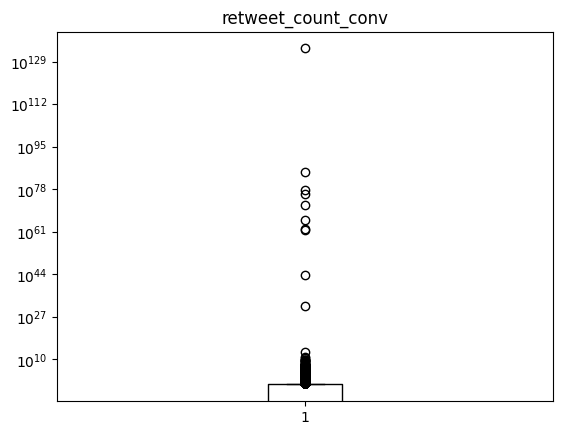

In [26]:
show_statistics(df_tweets,'retweet_count_conv', log=True)

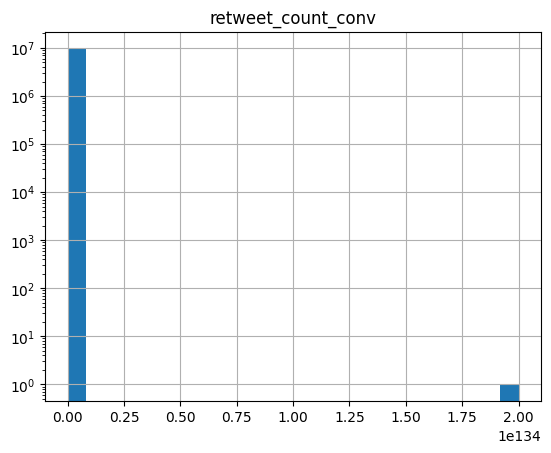

In [27]:
plot_hist(df_tweets[df_tweets['retweet_count_conv']!=np.inf], 'retweet_count_conv')

Analyze how boxplots change with different thresholds for the highest values (which are most likely noisy values).

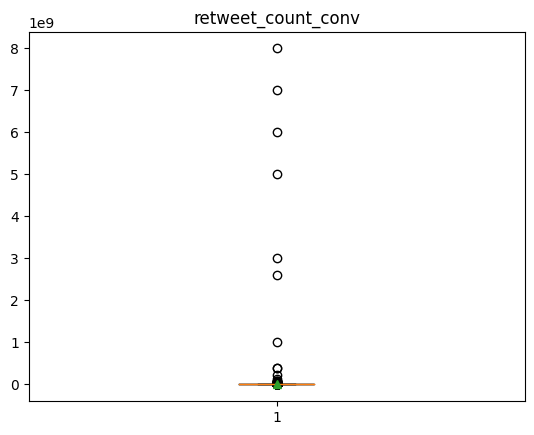

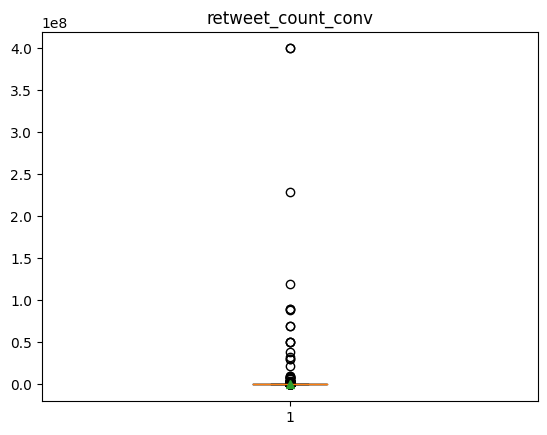

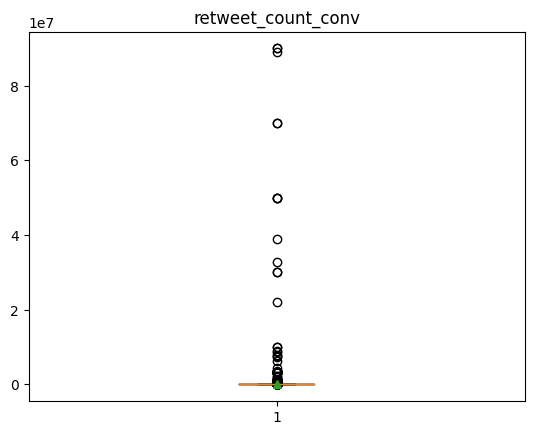

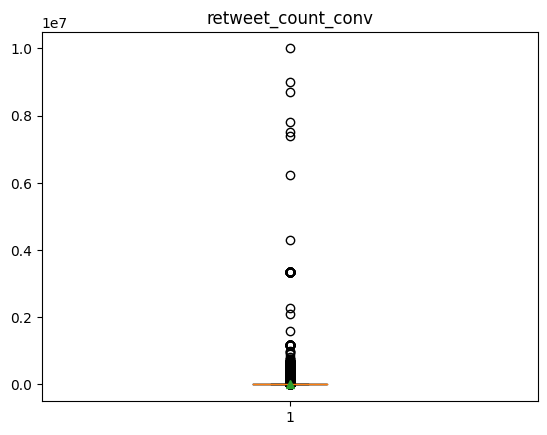

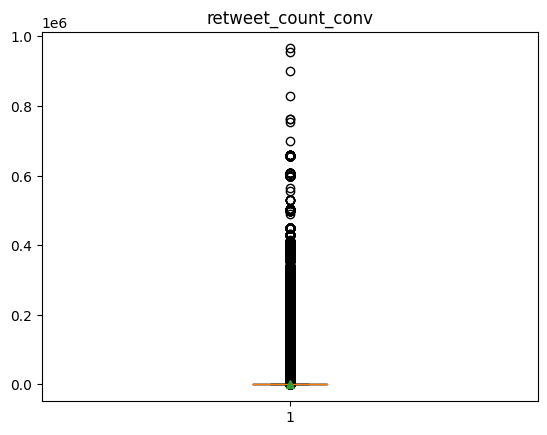

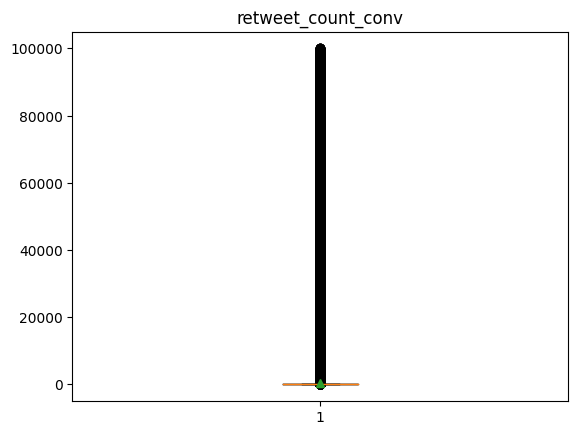

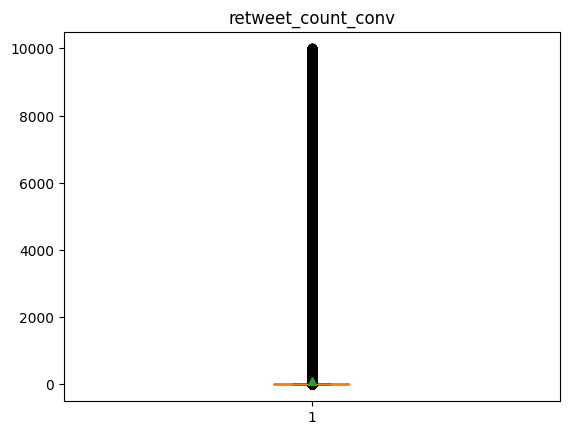

In [28]:
for p in range(10,3,-1):
    threshold = 10**p
    plot_boxplot(df_tweets[df_tweets.retweet_count_conv.values < threshold],'retweet_count_conv', log=False)

5 * 1e5 seems to be a reasonable threshold.

For the missing values (-1) and the values over the threshold we have checked if the same user has other tweets in the dataset to extract statistics from them. 

If there are not other tweets or there are only tweets with missing values the median over all the dataset is set as default.

In [29]:
threshold = 5e5
df_tweets = replace_with_user_median(df_tweets, 'retweet_count_conv', threshold=threshold)

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_20764\235777878.py:30: FutureWarning: ['created_at', 'text'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_stats = df_to_replace[condition_for_median].groupby(by=['user_id']).agg(["median", "var"])[attribute_name]


The distribution remains skewed, but it is better than before since different noisy values have been removed.

mean: 186.01773886956212
median: 0.0
entropy: 11.588566433798187


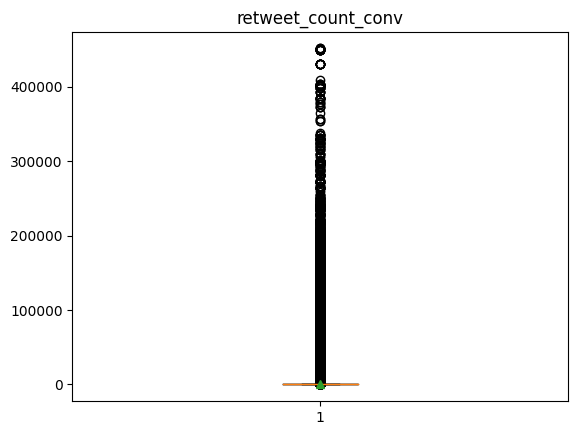

In [30]:
show_statistics(df_tweets,'retweet_count_conv')

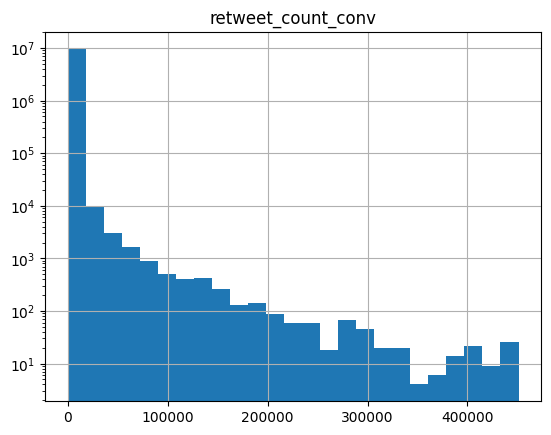

In [31]:
plot_hist(df_tweets, 'retweet_count_conv')

In [32]:
# Drop column with noisy values
df_tweets.drop(columns = ['retweet_count'], inplace=True)

Same procedure has been applied to `reply_count` and `favorite_count` columns with different thresholds (respectively 2e6 and 5e5).

# Clean reply_count column

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_entropy.py:77: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


mean: inf
median: 0.0
entropy: nan


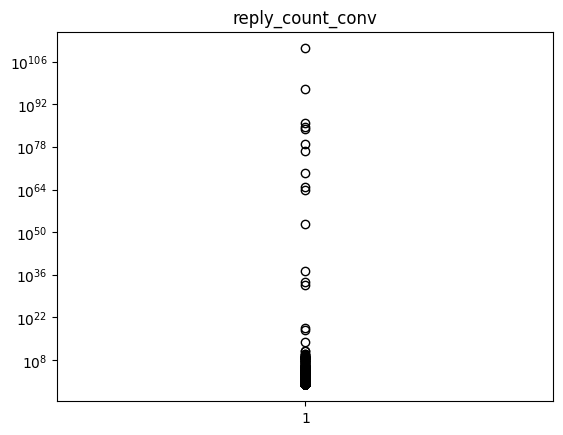

In [33]:
show_statistics(df_tweets,'reply_count_conv', log=True)

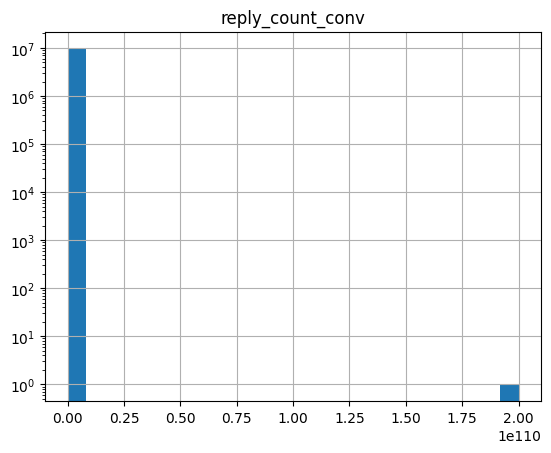

In [34]:
plot_hist(df_tweets[df_tweets['reply_count_conv']!=np.inf], 'reply_count_conv')

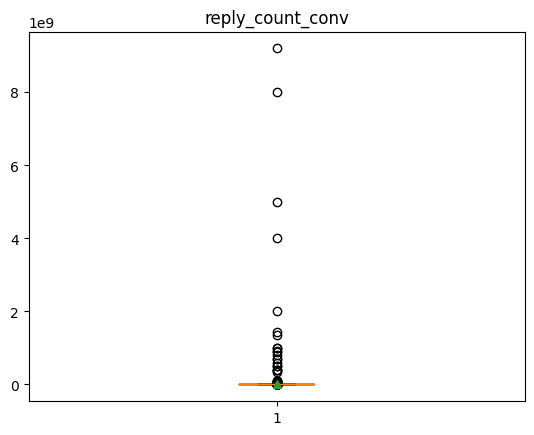

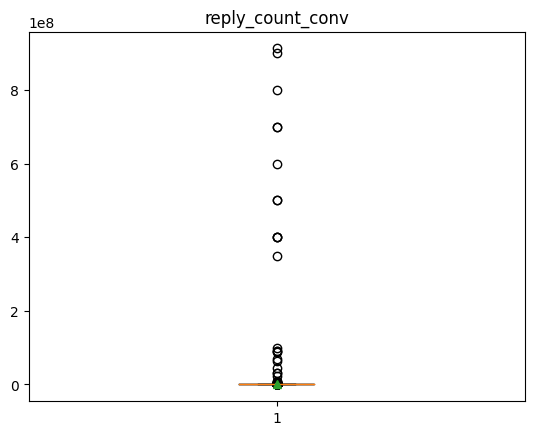

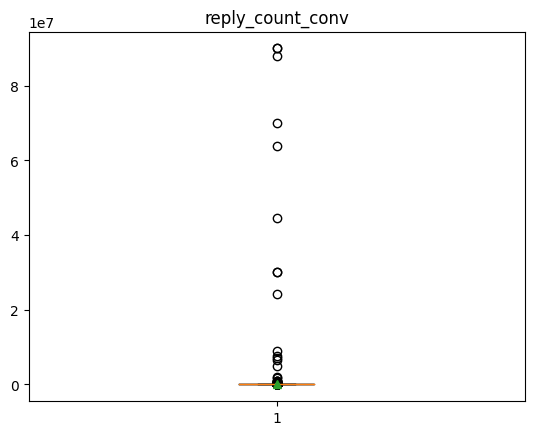

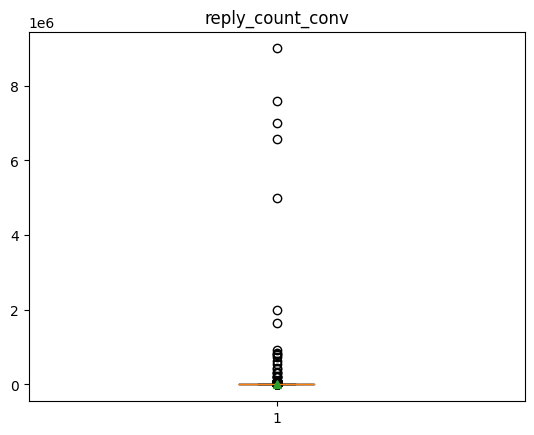

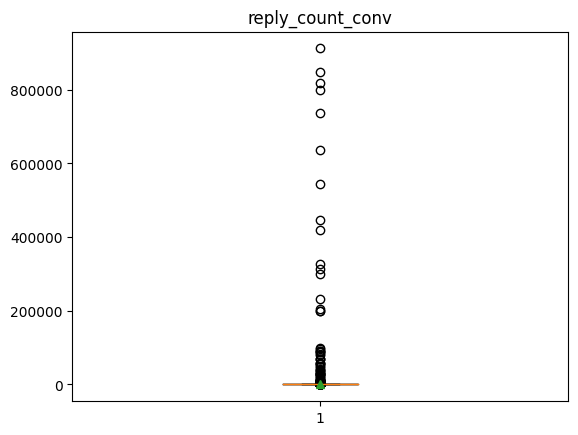

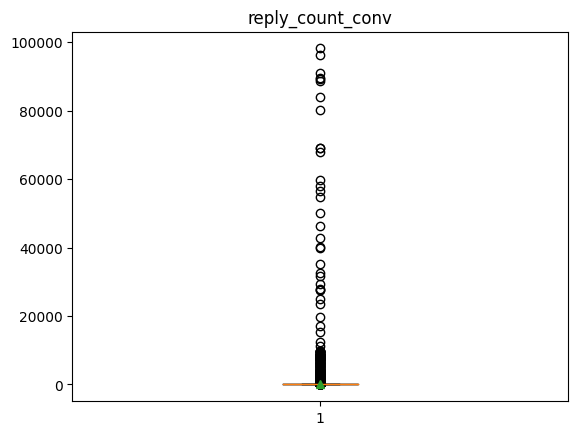

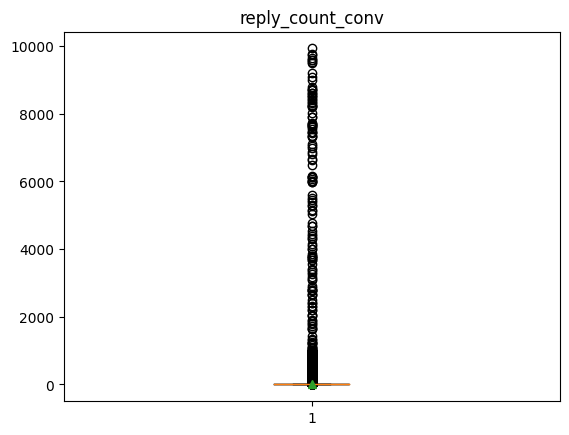

In [35]:
for p in range(10,3,-1):
    threshold = 10**p
    plot_boxplot(df_tweets[df_tweets.reply_count_conv.values < threshold],'reply_count_conv', log=False)

Cutting at 2 millions  or 600000 seems to be a reasonable choidce

In [36]:
threshold =2e6
df_tweets = replace_with_user_median(df_tweets, 'reply_count_conv', threshold=threshold)

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_20764\235777878.py:30: FutureWarning: ['created_at', 'text'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_stats = df_to_replace[condition_for_median].groupby(by=['user_id']).agg(["median", "var"])[attribute_name]


mean: 1.095740560583912
median: 0.0
entropy: 3.427646669364797


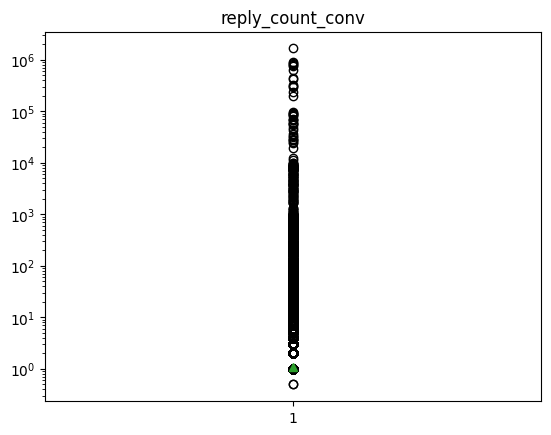

In [37]:
show_statistics(df_tweets,'reply_count_conv', True)

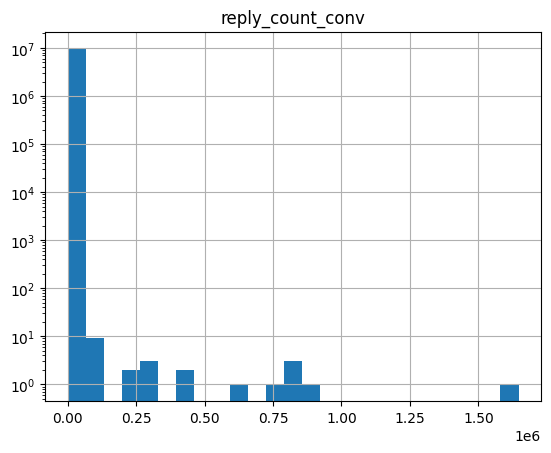

In [38]:
plot_hist(df_tweets, 'reply_count_conv')

In [39]:
df_tweets.drop(columns = ['reply_count'], inplace=True)

# Clean favorite_count column

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_entropy.py:77: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


mean: inf
median: 0.0
entropy: nan


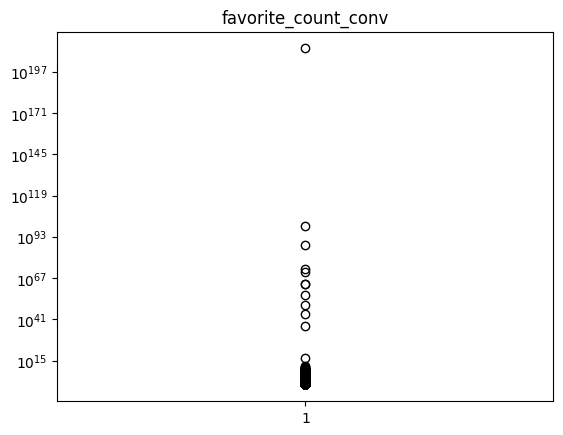

In [40]:
show_statistics(df_tweets,'favorite_count_conv', log=True)

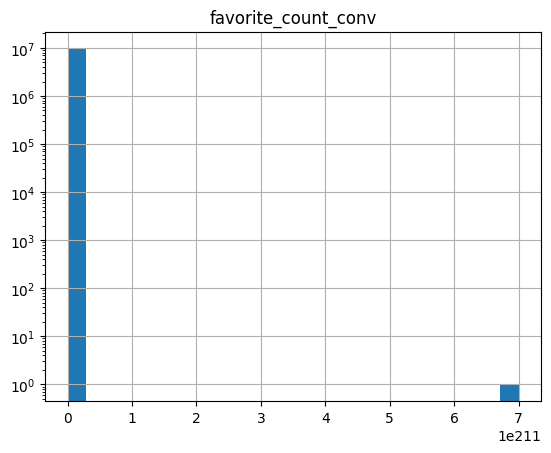

In [41]:
plot_hist(df_tweets[df_tweets['favorite_count_conv']!=np.inf], 'favorite_count_conv')

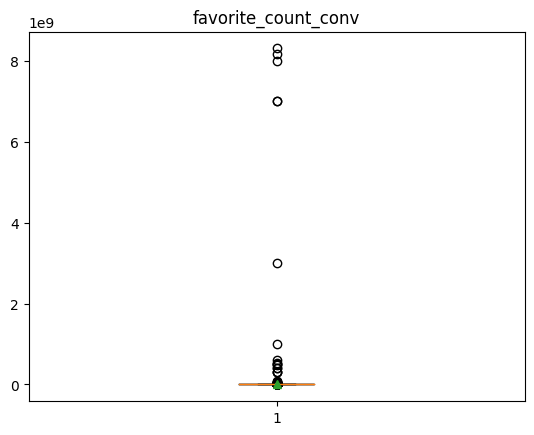

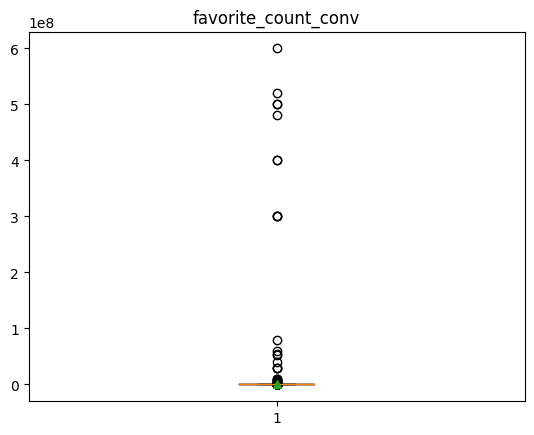

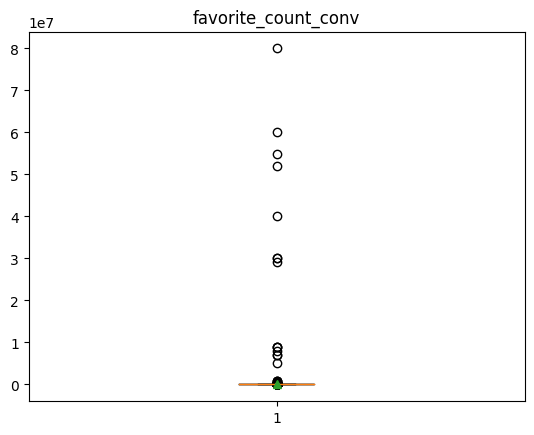

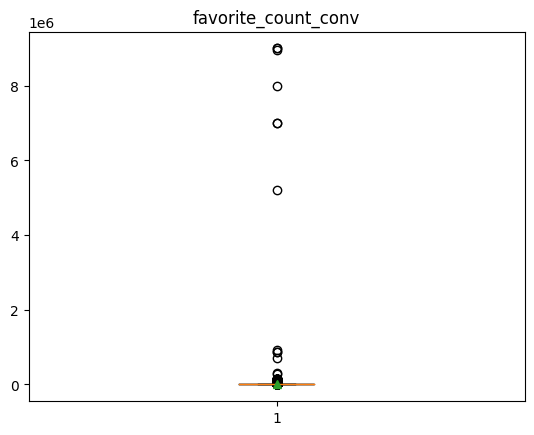

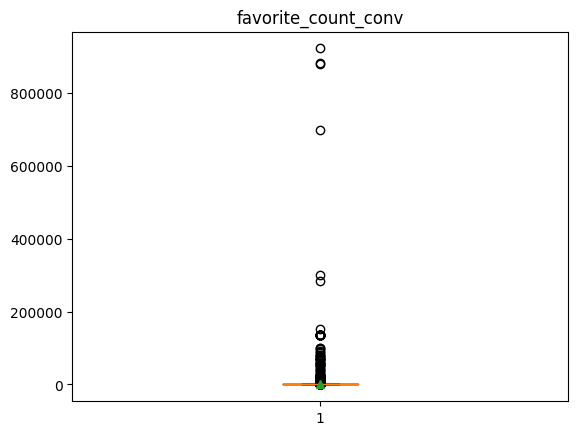

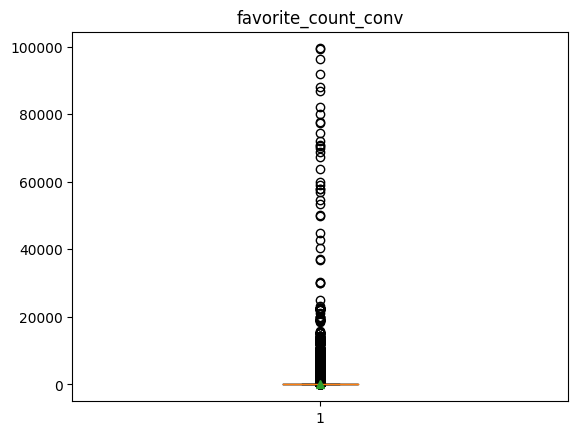

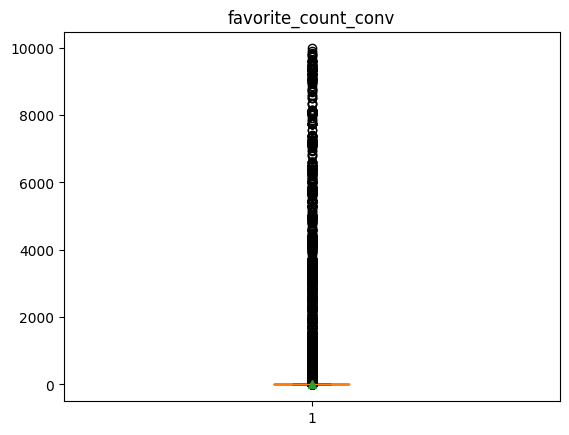

In [42]:
for p in range(10,3,-1):
    threshold = 10**p
    plot_boxplot(df_tweets[df_tweets.favorite_count_conv.values < threshold],'favorite_count_conv', log=False)

5e5 seems a reasonable point to cut

In [43]:
threshold = 5e5
df_tweets = replace_with_user_median(df_tweets, 'favorite_count_conv', threshold=threshold)

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_20764\235777878.py:30: FutureWarning: ['created_at', 'text'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_stats = df_to_replace[condition_for_median].groupby(by=['user_id']).agg(["median", "var"])[attribute_name]


mean: 1.9063277322480912
median: 0.0
entropy: 8.544106368251835


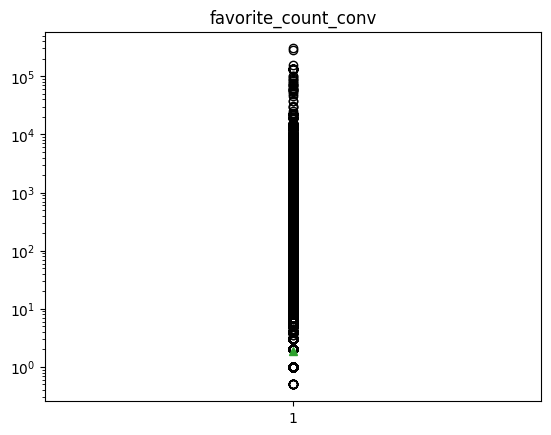

In [44]:
show_statistics(df_tweets,'favorite_count_conv', True)

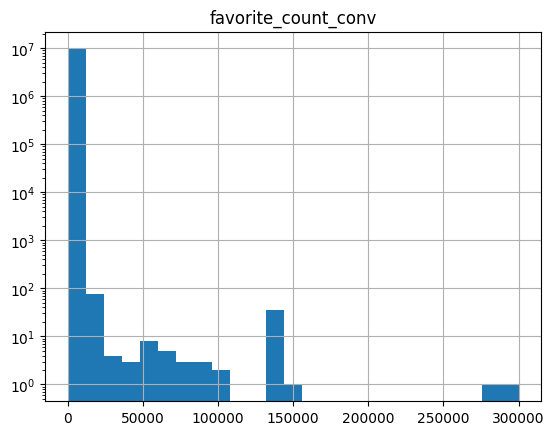

In [45]:
plot_hist(df_tweets, 'favorite_count_conv')

In [46]:
df_tweets.drop(columns = ['favorite_count'], inplace=True)

# File checkpoint

In [47]:
df_tweets.to_csv(path_or_buf=DATA_PATH+'tweets_clean_counts.csv', sep='#', index=False)

In [11]:
df_tweets = pd.read_csv(DATA_PATH+'tweets_clean_counts.csv', sep='#')

# Created at

mean: 1.568855116221584e+18
median: 1.5726412485e+18
entropy: 16.09950461486415


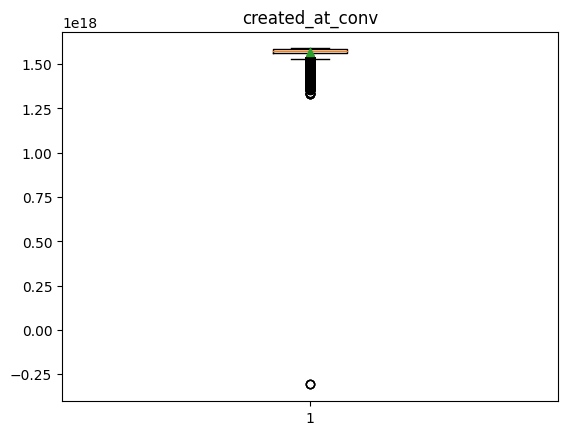

In [48]:
show_statistics(df_tweets,'created_at_conv', log=False, norm=True)

In [49]:
# Select tweets between the foundation of Twitter
twitter_foundation = pd.to_datetime(["20060321"]).astype(np.int64)[0]
# and the time in which the dataset was given to us
sep_2022 = pd.to_datetime(["20220915"]).astype(np.int64)[0]
twitter_foundation

1142899200000000000

In [50]:
# Replace all tweets outside of this bounds (before foundation and after September 2022)
replace_condition= lor(df_tweets.created_at_conv < twitter_foundation, df_tweets.created_at_conv > sep_2022)

# Replace these dates with (user) median
df_tweets = replace_with_user_median(df_tweets, 'created_at_conv', replace_tweets_condition=replace_condition)

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_20764\235777878.py:30: FutureWarning: ['created_at', 'text'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_stats = df_to_replace[condition_for_median].groupby(by=['user_id']).agg(["median", "var"])[attribute_name]


In [51]:
df_tweets['created_at'] = pd.to_datetime(df_tweets.created_at_conv)

Check that user tweets have created_at set after its subscription to twitter

In [52]:
df_users.id = df_users.id.astype(str)
df_merged = df_tweets.merge(df_users, left_on='user_id', right_on='id', how='left')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9816550 entries, 0 to 9816549
Data columns (total 22 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   level_0                    int64         
 1   user_id                    object        
 2   created_at                 datetime64[ns]
 3   text                       object        
 4   num_hashtags               float64       
 5   num_urls                   float64       
 6   num_mentions               float64       
 7   user_id_conv               float64       
 8   created_at_conv            int64         
 9   retweet_count_conv         float64       
 10  reply_count_conv           float64       
 11  favorite_count_conv        float64       
 12  num_hashtags_conv          float64       
 13  num_urls_conv              float64       
 14  num_mentions_conv          float64       
 15  id                         object        
 16  name                       object   

No user has tweets before the creation of its profile

In [53]:
df_merged[df_merged.created_at_conv < df_merged.user_subscription_in_secs]

,level_0,user_id,created_at,text,num_hashtags,num_urls,num_mentions,user_id_conv,created_at_conv,retweet_count_conv,...,num_hashtags_conv,num_urls_conv,num_mentions_conv,id,name,lang,bot,user_subscription,statuses_count,user_subscription_in_secs


In [54]:
df_tweets[df_tweets.created_at_conv == df_tweets.created_at_conv.max()]

,level_0,user_id,created_at,text,num_hashtags,num_urls,num_mentions,user_id_conv,created_at_conv,retweet_count_conv,reply_count_conv,favorite_count_conv,num_hashtags_conv,num_urls_conv,num_mentions_conv
344590,344870,476876406,2020-05-03 10:36:12,RT @people: It's a princess! William and Kate ...,1.0,1.0,1.0,476876406.0,1588502172000000000,2.0,0.0,0.0,1.0,1.0,1.0


In [55]:
df_tweets[df_tweets.created_at_conv == df_tweets.created_at_conv.min()]

,level_0,user_id,created_at,text,num_hashtags,num_urls,num_mentions,user_id_conv,created_at_conv,retweet_count_conv,reply_count_conv,favorite_count_conv,num_hashtags_conv,num_urls_conv,num_mentions_conv
2704101,2723546,887281,2012-03-11 22:25:59,Back from eating at Jamon Jamon.,0.0,0.0,0.0,887281.0,1331504759000000000,0.0,0.0,0.0,0.0,0.0,0.0


The distribution has significantly improved after removing all the noisy values.

mean: 1.5688553971486694e+18
median: 1.572641148e+18
entropy: 16.094390701644457


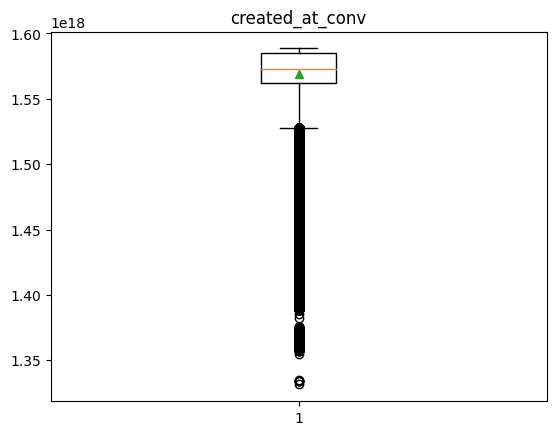

In [56]:
show_statistics(df_tweets, 'created_at_conv', log=False, norm=True)

# File checkpoint

In [57]:
df_tweets.to_csv(path_or_buf=DATA_PATH+'tweets_clean_created_at.csv', sep='#', index=False)

In [7]:
df_tweets = pd.read_csv(DATA_PATH+'tweets_clean_created_at.csv', sep='#')

# Number of hashtags

An hashtag is composed by at least 2 characters, the `#` and an alphanumeric symbol. Since the 8th of november 2017 a tweet is made by at most 280 characters, before 2017, the maximum was 140. So the maximum number of hashtags in a tweet before 2017-11-8 should be 70, after 2017-11-8 140.

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_entropy.py:77: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


mean: inf
median: 0.0
entropy: nan


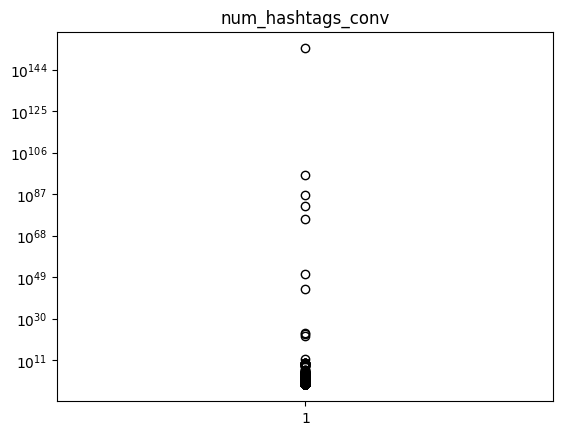

In [58]:
show_statistics(df_tweets, 'num_hashtags_conv', log=True)

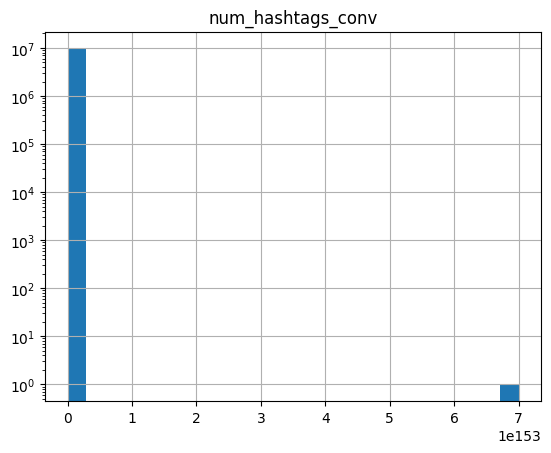

In [59]:
plot_hist(df_tweets[df_tweets.num_hashtags_conv != np.inf], 'num_hashtags_conv')

In [60]:
double_char_date = pd.to_datetime(["20171108"]).astype(np.int64)[0]

In [61]:
max_hash_num = 140/3

# Conditions on dates
date_cond = df_tweets.created_at_conv < double_char_date
# and maximum number if hashtags
max_cond = df_tweets.num_hashtags_conv > max_hash_num
# and noisy values
wrong_cond = df_tweets.num_hashtags_conv == -1
replace_cond = land(lor(max_cond, wrong_cond), date_cond)

replace_value = df_tweets[land(date_cond, land(~max_cond, ~wrong_cond))].num_hashtags_conv.median()

df_tweets = fix_values(df_tweets, 'num_hashtags_conv', replace_cond, replace_value)

In [62]:
max_hash_num = 280/3

# Conditions on dates
date_cond = df_tweets.created_at_conv > double_char_date
# and maximum number if hashtags
max_cond = df_tweets.num_hashtags_conv > max_hash_num
# and noisy values
wrong_cond = df_tweets.num_hashtags_conv == -1
replace_cond = land(lor(max_cond, wrong_cond), date_cond)

replace_value = df_tweets[land(date_cond, land(~max_cond, ~wrong_cond))].num_hashtags_conv.median()

df_tweets = fix_values(df_tweets, 'num_hashtags_conv', replace_cond, replace_value)

mean: 0.1748582750559005
median: 0.0
entropy: 13.733821948302717


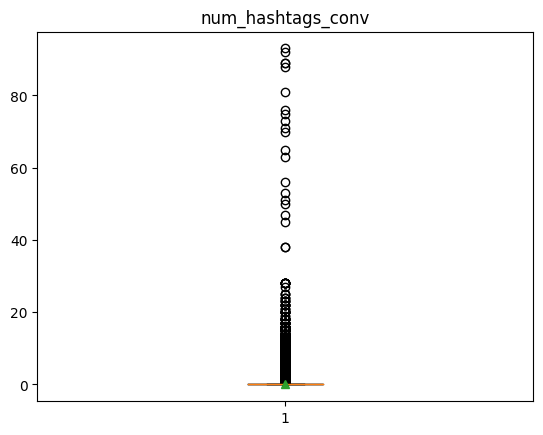

In [63]:
show_statistics(df_tweets, 'num_hashtags_conv')

In [64]:
# Tweet with maximum number of hashtags
df_tweets[df_tweets.num_hashtags_conv == df_tweets.num_hashtags_conv.max()]

,level_0,user_id,created_at,text,num_hashtags,num_urls,num_mentions,user_id_conv,created_at_conv,retweet_count_conv,reply_count_conv,favorite_count_conv,num_hashtags_conv,num_urls_conv,num_mentions_conv
197127,197215,27164845,2019-10-03 07:08:56,Man ion feel like going to work tomorrow that ...,93.0,0.0,0.0,27164845.0,1570086536000000000,0.0,0.0,0.0,93.0,0.0,0.0


In [65]:
df_tweets.drop(columns = ['num_hashtags'], inplace=True)

# Number of mentions

A mention is composed by at least 2 characters, the `@` and an alphanumeric symbol. Since the 8th of november 2017 a tweet is made by at most 280 characters, before 2017, the maximum was 140. So the maximum number of mention in a tweet before 2017-11-8 should be 70, after 2017-11-8 140.

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_entropy.py:77: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


mean: inf
median: 0.0
entropy: nan


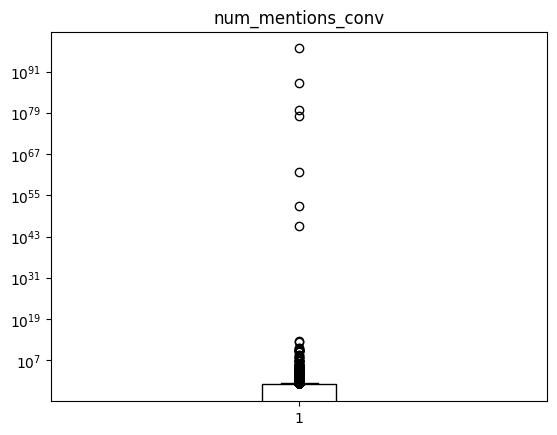

In [66]:
show_statistics(df_tweets, 'num_mentions_conv', log=True)

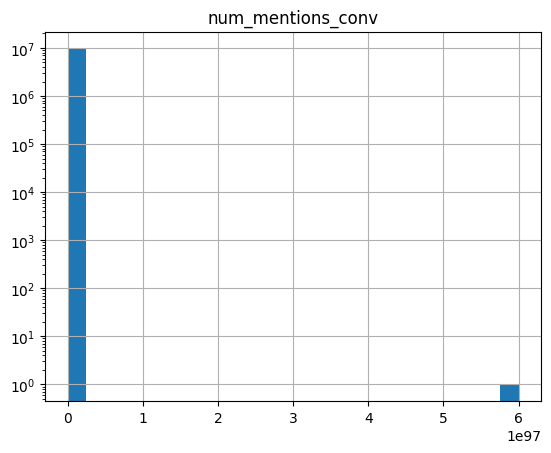

In [67]:
plot_hist(df_tweets[df_tweets.num_mentions_conv != np.inf], 'num_mentions_conv')

In [68]:
double_char_date = pd.to_datetime(["20171108"]).astype(np.int64)[0]

In [69]:
max_mentions_num = 140/3

# Conditions on dates
date_cond = df_tweets.created_at_conv < double_char_date
# and maximum number if hashtags
max_cond = df_tweets.num_mentions_conv > max_mentions_num
# and noisy values
wrong_cond = df_tweets.num_mentions_conv == -1
replace_cond = land(lor(max_cond, wrong_cond), date_cond)

replace_value = df_tweets[land(date_cond, land(~max_cond, ~wrong_cond))].num_mentions_conv.median()

df_tweets = fix_values(df_tweets, 'num_mentions_conv', replace_cond, replace_value)

In [70]:
max_mentions_num = 280/3

# Conditions on dates
date_cond = df_tweets.created_at_conv > double_char_date
# and maximum number if hashtags
max_cond = df_tweets.num_mentions_conv > max_mentions_num
# and noisy values
wrong_cond = df_tweets.num_mentions_conv == -1
replace_cond = land(lor(max_cond, wrong_cond), date_cond)

replace_value = df_tweets[land(date_cond, land(~max_cond, ~wrong_cond))].num_mentions_conv.median()

df_tweets = fix_values(df_tweets, 'num_mentions_conv', replace_cond, replace_value)

mean: 0.5210866343063499
median: 0.0
entropy: 15.061128183315262


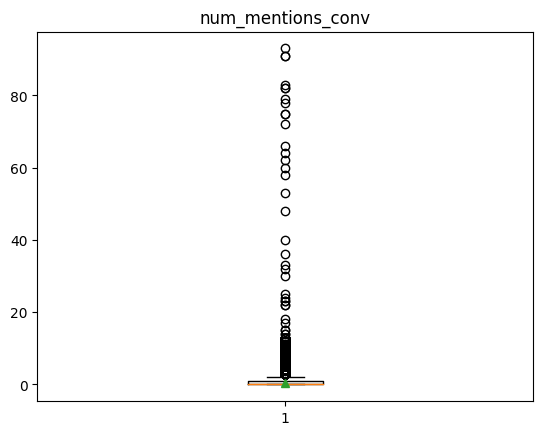

In [71]:
show_statistics(df_tweets, 'num_mentions_conv')

In [72]:
# Tweet with maximum number of mentions
df_tweets[df_tweets.num_mentions_conv == df_tweets.num_mentions_conv.max()]

,level_0,user_id,created_at,text,num_urls,num_mentions,user_id_conv,created_at_conv,retweet_count_conv,reply_count_conv,favorite_count_conv,num_hashtags_conv,num_urls_conv,num_mentions_conv
9062031,9362590,243926487,2020-01-23 12:26:28,Are you a leader or a follower? — Depends on t...,1.0,93.0,243926487.0,1579782388000000000,0.0,0.0,0.0,0.0,1.0,93.0


In [73]:
df_tweets.drop(columns = ['num_mentions'], inplace=True)

# Num URLS

A URL is composed by at least 3 characters, like `a.co`. Since the 8th of november 2017 a tweet is made by at most 280 characters, before 2017, the maximum was 140. So the maximum number of urls in a tweet before 2017-11-8 should be 35, after 2017-11-8 70.

c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_entropy.py:77: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


mean: inf
median: 0.0
entropy: nan


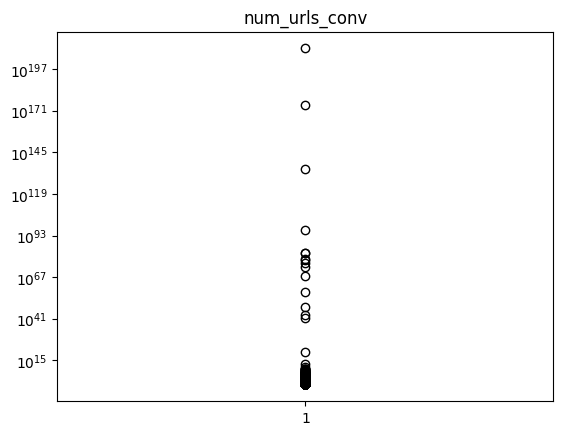

In [74]:
show_statistics(df_tweets, 'num_urls_conv', log=True)

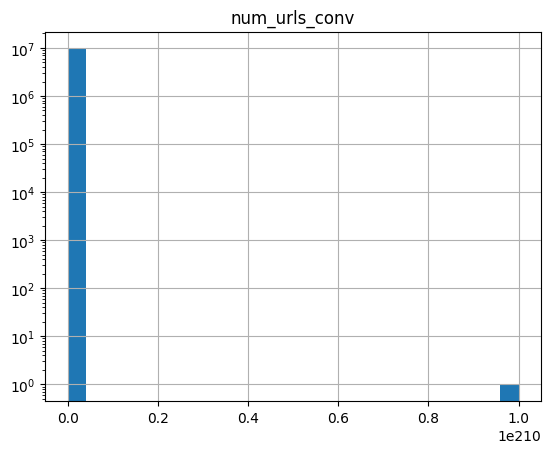

In [75]:
plot_hist(df_tweets[df_tweets.num_urls_conv != np.inf], 'num_urls_conv')

In [76]:
double_char_date = pd.to_datetime(["20171108"]).astype(np.int64)[0]

In [77]:
max_url_num = 140/5

# Conditions on dates
date_cond = df_tweets.created_at_conv < double_char_date
# and maximum number if hashtags
max_cond = df_tweets.num_urls_conv > max_url_num
# and noisy values
wrong_cond = df_tweets.num_urls_conv == -1
replace_cond = land(lor(max_cond, wrong_cond), date_cond)

replace_value = df_tweets[land(date_cond, land(~max_cond, ~wrong_cond))].num_urls_conv.median()

df_tweets = fix_values(df_tweets, 'num_urls_conv', replace_cond, replace_value)

In [78]:
max_url_num = 280/5

# Conditions on dates
date_cond = df_tweets.created_at_conv > double_char_date
# and maximum number if hashtags
max_cond = df_tweets.num_urls_conv > max_url_num
# and noisy values
wrong_cond = df_tweets.num_urls_conv == -1
replace_cond = land(lor(max_cond, wrong_cond), date_cond)

replace_value = df_tweets[land(date_cond, land(~max_cond, ~wrong_cond))].num_urls_conv.median()

df_tweets = fix_values(df_tweets, 'num_urls_conv', replace_cond, replace_value)

mean: 0.16393508921158656
median: 0.0
entropy: 14.269621364048449


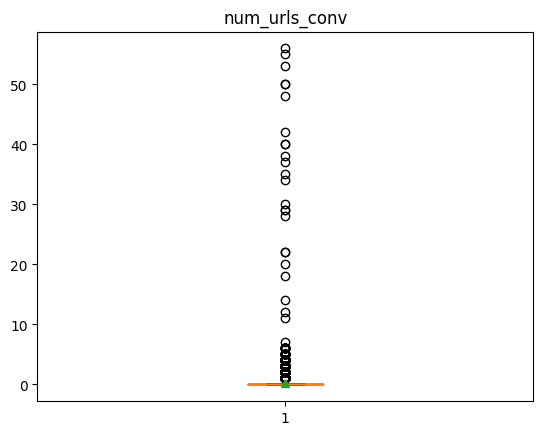

In [79]:
show_statistics(df_tweets, 'num_urls_conv')

In [80]:
# Tweet with maximum number of urls
df_tweets[df_tweets.num_urls_conv == df_tweets.num_urls_conv.max()]

,level_0,user_id,created_at,text,num_urls,user_id_conv,created_at_conv,retweet_count_conv,reply_count_conv,favorite_count_conv,num_hashtags_conv,num_urls_conv,num_mentions_conv
375031,375375,nan,2020-02-25 05:59:48,HELP!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,56.0,231957917.0,1582610388000000000,0.0,0.0,0.0,0.0,56.0,0.0


In [81]:
df_tweets.drop(columns = ['num_urls'], inplace=True)

In [82]:
# Rename all columns
df_tweets.rename(columns={"retweet_count_conv": "retweet_count", "reply_count_conv": "reply_count", "favorite_count_conv": "favorite_count",
                          "num_hashtags_conv": "num_hashtags", "num_urls_conv": "num_urls", "num_mentions_conv": "num_mentions", "created_at": "publication_date", "created_at_conv": "publication_date_in_secs"}, inplace = True)

In [83]:
# Cast them to int
df_tweets = df_tweets.astype({"retweet_count": 'int32', "reply_count": 'int32', "favorite_count" : 'int32',
                          "num_hashtags": 'int32', "num_urls": 'int32', "num_mentions": 'int32'})

In [84]:
df_tweets.drop(columns=['level_0', 'user_id_conv'], inplace=True)

In [85]:
df_tweets.to_csv(path_or_buf=DATA_PATH+'tweets_clean.csv', sep='#', index=False)